In [49]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [17]:
df_e = pd.read_csv('final_encoded.csv')
df_we = pd.read_csv('final_df.csv')

In [54]:
df_e

,metro_time,info_total_area,raion_Внуково поселок,raion_Внуковское поселение,raion_Десеновское поселение,raion_Завода Мосрентген поселок,raion_Ивановское деревня,raion_Кокошкино дп,raion_Кокошкино поселение,raion_Коммунарка поселок,raion_Марушкинское поселение,raion_Молодцы деревня,raion_Московский,raion_Московский поселение,raion_Новомосковский административный округ,raion_Новофедоровское поселение,raion_Первомайское поселок,raion_Подсобного хозяйства Воскресенское поселок,raion_Родниковая ул.,raion_Рязановское поселение,raion_Скандинавия жилой комплекс,raion_Сосенское поселение,raion_ТАО (Троицкий),raion_Троицк,raion_Филимонковское поселение,raion_Щапово поселок,raion_Щербинка,raion_бул. Веласкеса,raion_бул. Севильский,raion_бул. Скандинавский,raion_проезд Чечерский,raion_просп. Магеллана,raion_просп. Нововатутинский,raion_просп. Прокшинский,raion_р-н Академический,raion_р-н Алексеевский,raion_р-н Алтуфьевский,raion_р-н Арбат,raion_р-н Аэропорт,raion_р-н Бабушкинский,raion_р-н Басманный,raion_р-н Беговой,raion_р-н Бескудниковский,raion_р-н Бибирево,raion_р-н Бирюлево Восточное,raion_р-н Бирюлево Западное,raion_р-н Богородское,raion_р-н Братеево,raion_р-н Бутырский,raion_р-н Вешняки,raion_р-н Внуково,raion_р-н Войковский,raion_р-н Восточное Дегунино,raion_р-н Восточное Измайлово,raion_р-н Выхино-Жулебино,raion_р-н Гагаринский,raion_р-н Головинский,raion_р-н Гольяново,raion_р-н Даниловский,raion_р-н Дмитровский,raion_р-н Донской,raion_р-н Дорогомилово,raion_р-н Западное Дегунино,raion_р-н Зюзино,raion_р-н Зябликово,raion_р-н Ивановское,raion_р-н Измайлово,raion_р-н Капотня,raion_р-н Коньково,raion_р-н Коптево,raion_р-н Косино-Ухтомский,raion_р-н Котловка,raion_р-н Красносельский,raion_р-н Крылатское,raion_р-н Крюково,raion_р-н Кузьминки,raion_р-н Кунцево,raion_р-н Куркино,raion_р-н Левобережный,raion_р-н Лефортово,raion_р-н Лианозово,raion_р-н Ломоносовский,raion_р-н Лосиноостровский,raion_р-н Люблино,raion_р-н Марфино,raion_р-н Марьина роща,raion_р-н Марьино,raion_р-н Матушкино,raion_р-н Метрогородок,raion_р-н Мещанский,raion_р-н Митино,raion_р-н Можайский,raion_р-н Молжаниновский,raion_р-н Москворечье-Сабурово,raion_р-н Нагатино-Садовники,raion_р-н Нагатинский затон,raion_р-н Нагорный,raion_р-н Некрасовка,raion_р-н Нижегородский,raion_р-н Ново-Переделкино,raion_р-н Новогиреево,raion_р-н Новокосино,raion_р-н Обручевский,raion_р-н Орехово-Борисово Северное,raion_р-н Орехово-Борисово Южное,raion_р-н Останкинский,raion_р-н Отрадное,raion_р-н Очаково-Матвеевское,raion_р-н Перово,raion_р-н Печатники,raion_р-н Покровское-Стрешнево,raion_р-н Преображенское,raion_р-н Пресненский,raion_р-н Проспект Вернадского,raion_р-н Раменки,raion_р-н Ростокино,raion_р-н Рязанский,raion_р-н Савеловский,raion_р-н Савёлки,raion_р-н Свиблово,raion_р-н Северное Бутово,raion_р-н Северное Измайлово,raion_р-н Северное Медведково,raion_р-н Северное Тушино,raion_р-н Северный,raion_р-н Силино,raion_р-н Сокол,raion_р-н Соколиная гора,raion_р-н Сокольники,raion_р-н Солнцево,raion_р-н Старое Крюково,raion_р-н Строгино,raion_р-н Таганский,raion_р-н Тверской,raion_р-н Текстильщики,raion_р-н Теплый Стан,raion_р-н Тимирязевский,raion_р-н Тропарево-Никулино,raion_р-н Филевский парк,raion_р-н Фили-Давыдково,raion_р-н Хамовники,raion_р-н Ховрино,raion_р-н Хорошево-Мневники,raion_р-н Хорошевский,raion_р-н Царицыно,raion_р-н Черемушки,raion_р-н Чертаново Северное,raion_р-н Чертаново Центральное,raion_р-н Чертаново Южное,raion_р-н Щукино,raion_р-н Южное Бутово,raion_р-н Южное Медведково,raion_р-н Южное Тушино,raion_р-н Южнопортовый,raion_р-н Ярославский,raion_р-н Ясенево,raion_ул. 1-я Ватутинская,raion_ул. 1-я Нововатутинская,raion_ул. Аэростатная,raion_ул. Большое Понизовье,raion_ул. Генерала Пилипенко,raion_ул. Гренадерская,raion_ул. Кварцевая,raion_ул. Лобановский Лес,raion_ул. Малое Понизовье,raion_ул. Медовая Долина,raion_ул. Саларьевская,raion_ул. Сальвадора Дали,raion_ул. Татьянин Парк,raion_ул. Трехполье,raion_ул. Усадебный Парк,raion_ул. Харлампиева,raion_ш. Нов

In [18]:
y = df_e['price']

In [19]:
df_e = df_e.drop(columns=['price'])
df_we = df_we.drop(columns=['price'])

In [13]:
numeric_features = ['metro_time', 'info_total_area']
X = df_e[numeric_features]

# Добавляем константу для расчета VIF
X_const = add_constant(X)

# Считаем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Убираем константу из финального вывода
vif_data = vif_data[vif_data['Feature'] != 'const']

print(vif_data)

           Feature       VIF
1       metro_time  1.002853
2  info_total_area  1.002853


In [50]:
X = df_e.copy()

# Группируем колонки по группам
groups = {
    'okrug': [col for col in X.columns if col.startswith('okrug_')],
    'raion': [col for col in X.columns if col.startswith('raion_')],
    'rooms': [col for col in X.columns if col.startswith('rooms_')],
    'rent_jkh': [col for col in X.columns if col.startswith('rent_jkh_')],
    'rent_prepayment': [col for col in X.columns if col.startswith('rent_prepayment_')],
    'rent_term': [col for col in X.columns if col.startswith('rent_term_')],
    'rent_living_conditions': [col for col in X.columns if col.startswith('rent_living_conditions_')],
    'year_built_interval': [col for col in X.columns if col.startswith('year_built_interval_')],
    'metro_time': ['metro_time'],
    'info_total_area': ['info_total_area']
}

# Результаты VIF
vif_results = []

# Для каждой группы признаков
for group_name, group_features in groups.items():
    # Выбираем фичи вне текущей группы
    other_features = X.columns.difference(group_features)

    for feature in group_features:
        # Целевая переменная — текущая дамми-переменная
        y = X[feature]

        # Регрессоры — все переменные, кроме своих
        X_temp = X[other_features]
        X_temp_const = add_constant(X_temp)

        # Строим модель
        model = LinearRegression().fit(X_temp_const, y)
        y_pred = model.predict(X_temp_const)

        # Считаем R^2
        r_squared = r2_score(y, y_pred)

        # Считаем VIF по формуле
        if r_squared != 1:
            vif = 1 / (1 - r_squared)
        else:
            vif = float('inf')  # Если R^2 == 1, значит идеальная линейная зависимость

        vif_results.append({
            'group': group_name,
            'feature': feature,
            'R_squared': r_squared,
            'VIF': vif
        })

# Собираем всё в DataFrame
vif_df = pd.DataFrame(vif_results)

# Сортируем по убыванию VIF
vif_df = vif_df.sort_values(by='VIF', ascending=False)

     group                          feature  R_squared       VIF
0    okrug                        okrug_ВАО   1.000000       inf
1    okrug                        okrug_ЗАО   1.000000       inf
2    okrug                      okrug_ЗелАО   1.000000       inf
3    okrug       okrug_НАО (Новомосковский)   1.000000       inf
4    okrug                        okrug_САО   1.000000       inf
..     ...                              ...        ...       ...
185  raion             raion_ш. Рязановское   0.020080  1.020491
16   raion  raion_Завода Мосрентген поселок   0.019105  1.019478
178  raion        raion_ул. Сальвадора Дали   0.018605  1.018958
179  raion          raion_ул. Татьянин Парк   0.017757  1.018078
44   raion         raion_просп. Прокшинский   0.017624  1.017940

[211 rows x 4 columns]


In [52]:
vif_df

,group,feature,R_squared,VIF
0,okrug,okrug_ВАО,1.000000,inf
1,okrug,okrug_ЗАО,1.000000,inf
2,okrug,okrug_ЗелАО,1.000000,inf
3,okrug,okrug_НАО (Новомосковский),1.000000,inf
4,okrug,okrug_САО,1.000000,inf
...,...,...,...,...
185,raion,raion_ш. Рязановское,0.020080,1.020491
16,raion,raion_Завода Мосрентген поселок,0.019105,1.019478
178,raion,raion_ул. Сальвадора Дали,0.018605,1.018958
179,raion,raion_ул. Татьянин Парк,0.017757,1.018078


In [56]:
df_e = df_e.drop(columns=[col for col in df_e.columns if col.startswith('okrug_')])

df_e.head()

,metro_time,info_total_area,raion_Внуково поселок,raion_Внуковское поселение,raion_Десеновское поселение,raion_Завода Мосрентген поселок,raion_Ивановское деревня,raion_Кокошкино дп,raion_Кокошкино поселение,raion_Коммунарка поселок,raion_Марушкинское поселение,raion_Молодцы деревня,raion_Московский,raion_Московский поселение,raion_Новомосковский административный округ,raion_Новофедоровское поселение,raion_Первомайское поселок,raion_Подсобного хозяйства Воскресенское поселок,raion_Родниковая ул.,raion_Рязановское поселение,raion_Скандинавия жилой комплекс,raion_Сосенское поселение,raion_ТАО (Троицкий),raion_Троицк,raion_Филимонковское поселение,raion_Щапово поселок,raion_Щербинка,raion_бул. Веласкеса,raion_бул. Севильский,raion_бул. Скандинавский,raion_проезд Чечерский,raion_просп. Магеллана,raion_просп. Нововатутинский,raion_просп. Прокшинский,raion_р-н Академический,raion_р-н Алексеевский,raion_р-н Алтуфьевский,raion_р-н Арбат,raion_р-н Аэропорт,raion_р-н Бабушкинский,raion_р-н Басманный,raion_р-н Беговой,raion_р-н Бескудниковский,raion_р-н Бибирево,raion_р-н Бирюлево Восточное,raion_р-н Бирюлево Западное,raion_р-н Богородское,raion_р-н Братеево,raion_р-н Бутырский,raion_р-н Вешняки,raion_р-н Внуково,raion_р-н Войковский,raion_р-н Восточное Дегунино,raion_р-н Восточное Измайлово,raion_р-н Выхино-Жулебино,raion_р-н Гагаринский,raion_р-н Головинский,raion_р-н Гольяново,raion_р-н Даниловский,raion_р-н Дмитровский,raion_р-н Донской,raion_р-н Дорогомилово,raion_р-н Западное Дегунино,raion_р-н Зюзино,raion_р-н Зябликово,raion_р-н Ивановское,raion_р-н Измайлово,raion_р-н Капотня,raion_р-н Коньково,raion_р-н Коптево,raion_р-н Косино-Ухтомский,raion_р-н Котловка,raion_р-н Красносельский,raion_р-н Крылатское,raion_р-н Крюково,raion_р-н Кузьминки,raion_р-н Кунцево,raion_р-н Куркино,raion_р-н Левобережный,raion_р-н Лефортово,raion_р-н Лианозово,raion_р-н Ломоносовский,raion_р-н Лосиноостровский,raion_р-н Люблино,raion_р-н Марфино,raion_р-н Марьина роща,raion_р-н Марьино,raion_р-н Матушкино,raion_р-н Метрогородок,raion_р-н Мещанский,raion_р-н Митино,raion_р-н Можайский,raion_р-н Молжаниновский,raion_р-н Москворечье-Сабурово,raion_р-н Нагатино-Садовники,raion_р-н Нагатинский затон,raion_р-н Нагорный,raion_р-н Некрасовка,raion_р-н Нижегородский,raion_р-н Ново-Переделкино,raion_р-н Новогиреево,raion_р-н Новокосино,raion_р-н Обручевский,raion_р-н Орехово-Борисово Северное,raion_р-н Орехово-Борисово Южное,raion_р-н Останкинский,raion_р-н Отрадное,raion_р-н Очаково-Матвеевское,raion_р-н Перово,raion_р-н Печатники,raion_р-н Покровское-Стрешнево,raion_р-н Преображенское,raion_р-н Пресненский,raion_р-н Проспект Вернадского,raion_р-н Раменки,raion_р-н Ростокино,raion_р-н Рязанский,raion_р-н Савеловский,raion_р-н Савёлки,raion_р-н Свиблово,raion_р-н Северное Бутово,raion_р-н Северное Измайлово,raion_р-н Северное Медведково,raion_р-н Северное Тушино,raion_р-н Северный,raion_р-н Силино,raion_р-н Сокол,raion_р-н Соколиная гора,raion_р-н Сокольники,raion_р-н Солнцево,raion_р-н Старое Крюково,raion_р-н Строгино,raion_р-н Таганский,raion_р-н Тверской,raion_р-н Текстильщики,raion_р-н Теплый Стан,raion_р-н Тимирязевский,raion_р-н Тропарево-Никулино,raion_р-н Филевский парк,raion_р-н Фили-Давыдково,raion_р-н Хамовники,raion_р-н Ховрино,raion_р-н Хорошево-Мневники,raion_р-н Хорошевский,raion_р-н Царицыно,raion_р-н Черемушки,raion_р-н Чертаново Северное,raion_р-н Чертаново Центральное,raion_р-н Чертаново Южное,raion_р-н Щукино,raion_р-н Южное Бутово,raion_р-н Южное Медведково,raion_р-н Южное Тушино,raion_р-н Южнопортовый,raion_р-н Ярославский,raion_р-н Ясенево,raion_ул. 1-я Ватутинская,raion_ул. 1-я Нововатутинская,raion_ул. Аэростатная,raion_ул. Большое Понизовье,raion_ул. Генерала Пилипенко,raion_ул. Гренадерская,raion_ул. Кварцевая,raion_ул. Лобановский Лес,raion_ул. Малое Понизовье,raion_ул. Медовая Долина,raion_ул. Саларьевская,raion_ул. Сальвадора Дали,raion_ул. Татьянин Парк,raion_ул. Трехполье,raion_ул. Усадебный Парк,raion_ул. Харлампиева,raion_ш. Нов

In [60]:
X = df_e.copy()

# Группируем колонки по группам
groups = {
    'raion': [col for col in X.columns if col.startswith('raion_')],
    'rooms': [col for col in X.columns if col.startswith('rooms_')],
    'rent_jkh': [col for col in X.columns if col.startswith('rent_jkh_')],
    'rent_prepayment': [col for col in X.columns if col.startswith('rent_prepayment_')],
    'rent_term': [col for col in X.columns if col.startswith('rent_term_')],
    'rent_living_conditions': [col for col in X.columns if col.startswith('rent_living_conditions_')],
    'year_built_interval': [col for col in X.columns if col.startswith('year_built_interval_')],
    'metro_time': ['metro_time'],
    'info_total_area': ['info_total_area']
}

# Результаты VIF
vif_results = []

# Для каждой группы признаков
for group_name, group_features in groups.items():
    # Выбираем фичи вне текущей группы
    other_features = X.columns.difference(group_features)

    for feature in group_features:
        # Целевая переменная — текущая дамми-переменная
        y = X[feature]

        # Регрессоры — все переменные, кроме своих
        X_temp = X[other_features]
        X_temp_const = add_constant(X_temp)

        # Строим модель
        model = LinearRegression().fit(X_temp_const, y)
        y_pred = model.predict(X_temp_const)

        # Считаем R^2
        r_squared = r2_score(y, y_pred)

        # Считаем VIF по формуле
        if r_squared != 1:
            vif = 1 / (1 - r_squared)
        else:
            vif = float('inf')  # Если R^2 == 1, значит идеальная линейная зависимость

        vif_results.append({
            'group': group_name,
            'feature': feature,
            'R_squared': r_squared,
            'VIF': vif
        })

# Собираем всё в DataFrame
vif_df = pd.DataFrame(vif_results)

# Сортируем по убыванию VIF
vif_df = vif_df.sort_values(by='VIF', ascending=False)

In [61]:
vif_df

,group,feature,R_squared,VIF
197,info_total_area,info_total_area,0.795358,4.886590
178,rooms,rooms_студия,0.525986,2.109641
193,year_built_interval,year_built_interval_1970-1990,0.443461,1.796818
194,year_built_interval,year_built_interval_1991-2025,0.435269,1.770753
176,rooms,rooms_3,0.423976,1.736038
...,...,...,...,...
120,raion,raion_р-н Северное Медведково,0.014964,1.015191
29,raion,raion_просп. Магеллана,0.014898,1.015123
166,raion,raion_ул. Татьянин Парк,0.014112,1.014314
4,raion,raion_Ивановское деревня,0.013946,1.014143


In [59]:
X_encoded = df_e.copy()

# Обновляем groups (без okrug)
groups = {
    key: [col for col in cols if col in X_encoded.columns]
    for key, cols in groups.items()
    if key != 'okrug'  # полностью исключаем группу okrug
}

# Дальше твой код без изменений
model_full = LinearRegression()
model_full.fit(X_encoded, y)
coef_full = model_full.coef_

tolerance = 0.1
results = []

for group_name, group_features in groups.items():
    X_reduced = X_encoded.drop(columns=group_features)

    model_reduced = LinearRegression()
    model_reduced.fit(X_reduced, y)

    common_features = X_reduced.columns
    coef_reduced = model_reduced.coef_

    coef_diff = np.zeros(len(coef_full))
    for idx, feature in enumerate(X_encoded.columns):
        if feature in common_features:
            coef_diff[idx] = abs(coef_full[idx] - coef_reduced[list(common_features).index(feature)])
        else:
            coef_diff[idx] = 0

    max_change = coef_diff.max()
    mean_change = coef_diff.mean()
    num_significant_changes = (coef_diff > tolerance).sum()
    most_affected_feature = X_encoded.columns[np.argmax(coef_diff)]

    results.append({
        'group': group_name,
        'max_change': max_change,
        'mean_change': mean_change,
        'num_significant_changes': num_significant_changes,
        'most_affected_feature': most_affected_feature
    })

results_df = pd.DataFrame(results)
print(results_df)

                    group    max_change   mean_change  \
0                   raion  2.555475e-14  8.867040e-16   
1                   rooms  2.250912e-15  2.933446e-16   
2                rent_jkh  1.554312e-15  2.488965e-16   
3         rent_prepayment  1.110223e-15  1.563159e-16   
4               rent_term  1.665335e-15  2.337615e-16   
5  rent_living_conditions  2.664535e-15  2.379542e-16   
6     year_built_interval  2.331468e-15  2.229833e-16   
7              metro_time  8.626038e-14  4.483355e-15   
8         info_total_area  1.404040e+02  4.704035e+00   

   num_significant_changes  most_affected_feature  
0                        0          info_floor_23  
1                        0  raion_бул. Севильский  
2                        0        info_total_area  
3                        0        info_total_area  
4                        0        info_total_area  
5                        0        info_total_area  
6                        0        info_total_area  
7            

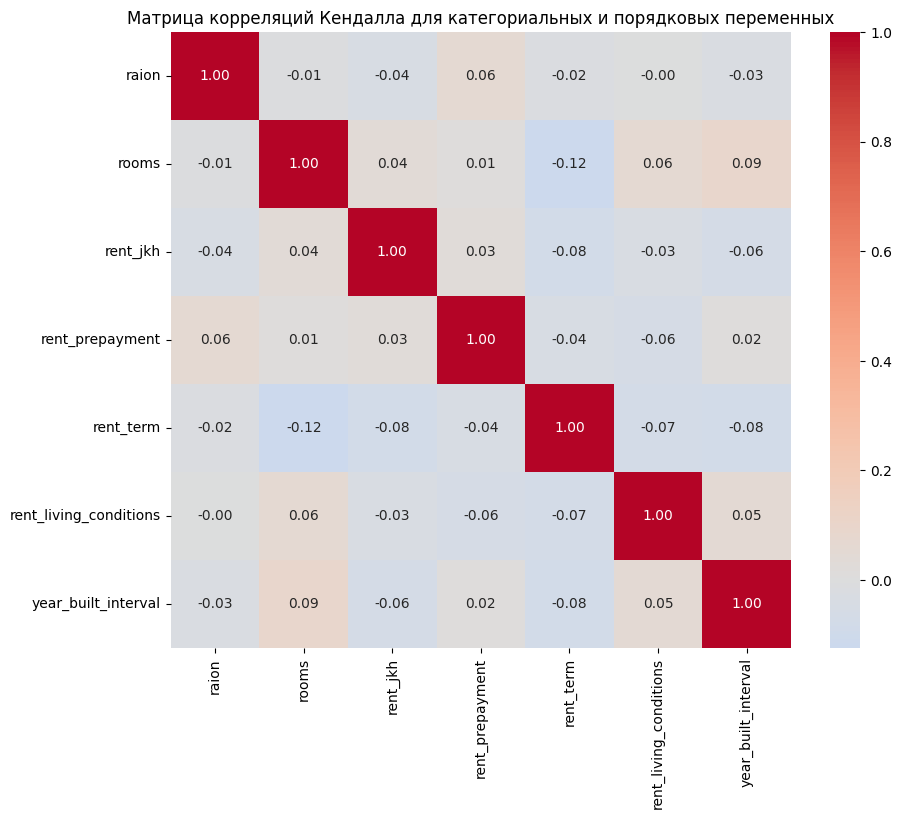

In [72]:
from sklearn.preprocessing import LabelEncoder

# Сначала копируем данные
df_encoded = df_we[categorical_ordinal_vars].copy()

# Преобразуем все категории в числа
label_encoders = {}
for col in categorical_ordinal_vars:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le  # если потом понадобится обратно декодировать

# Считаем корреляцию Кендалла
kendall_corr = df_encoded.corr(method='kendall')

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Матрица корреляций Кендалла для категориальных и порядковых переменных')
plt.show()
